# Setup

In [80]:
# imports
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, json
from sklearn_extra.cluster import KMedoids
from scipy.stats import percentileofscore

In [2]:
# get segmented df from other notebook
%store -r rfm_segments_df
rfm_df = rfm_segments_df.copy()
display(rfm_df.head())

,recency,frequency,monetary,segment
customer_id,,,,
1,183,3,118711.78,2
2,213,2,100306.58,0
3,188,4,119028.73,2
4,441,3,142874.25,0
5,132,4,120783.07,2


In [15]:
# get final cluster model
%store -r rfm_model
model = rfm_model
display(model)

KMedoids(init='k-medoids++', method='pam', n_clusters=3, random_state=42)

In [104]:
# save rfm col names
rfm_cols = ['recency', 'frequency', 'monetary']

# Describe Segments
---

## Analysis: Update Segment Labels

**Segment 1 <ins>(Potential Loyalists)**</ins>--> largest segment with 57.61% of customers and makes up largest portion of revenue with 59.72% of total revenue
- ***Monetary:*** <ins>above average</ins> (averaging $106,400.76 total spend)--> between 50th and 75th percentile
- ***Frequency:*** <ins>mid to slightly above average</ins> (averaging 3.3 orders per customer)--> around 50th and 75th percentile
- ***Recency:*** <ins>above average</ins> (averaging 120 days since last purchase)--> between 25th and 50th percentile--lower is better here

**Segment 2 <ins>(Hibernating)**</ins>--> second largest segment with 40.22% of customers and makes up only 24.99% of total revenue
- ***Monetary:*** <ins>significantly below average</ins> (averaging $63,785.26 total spend)--> below 25th percentile
- ***Frequency:*** <ins>below average</ins> (averaging 2.08 orders per customer)--> around 25th percentile
- ***Recency:*** <ins>significantly below average</ins> (averaging 296 days since last purchase)--> greater than 75th percentile

**Segment 3 <ins>(Champions)**</ins>--> very small segment with only 2.17% of customers yet makes up 15.28% of total revenue
- ***Monetary:*** <ins>significantly above average</ins> (averaging $721,462.27 total spend)--> above 75th percentile
- ***Frequency:*** <ins>significantly above average</ins> (averaging 19.5 orders per customer)--> above 75th percentile
- ***Recency:*** <ins>significantly above average</ins> (averaging 34.5 days since last purchase)--> less than 25th percentile

In [45]:
# update segment labels
segment_labels_dict = {
    2: 'Potential Loyalist',
    0: 'Hibernating',
    1: 'Champion'
}
rfm_df['segment'] = rfm_df['segment'].replace(segment_labels_dict)

rfm_df.head()

,recency,frequency,monetary,segment
customer_id,,,,
1,183,3,118711.78,Potential Loyalist
2,213,2,100306.58,Hibernating
3,188,4,119028.73,Potential Loyalist
4,441,3,142874.25,Hibernating
5,132,4,120783.07,Potential Loyalist


## Cluster Centers

In [46]:
# find customers that represent each segment
medoids_df = rfm_df.iloc[model.medoid_indices_].sort_values('monetary', ascending=False)
display(medoids_df)

,recency,frequency,monetary,segment
customer_id,,,,
91,55,16,647596.31,Champion
64,125,3,104561.96,Potential Loyalist
25,300,2,66560.57,Hibernating


## Percentiles

### Function

In [114]:
# function: get percentile of value based on column
def pct_rank(
    series: pd.Series,
    value,
    higher_better: bool=True,
    decimal_no_pct: bool=False
):
    '''
    returns percentile of value based on column
    allows for 'recency' higher != better correction
    '''
    p = percentileofscore(series, value, kind='rank')
    p = p if higher_better else 100 - p
    
    return p / 100 if decimal_no_pct else p

### Cluster Centers

**Analysis**

Note: cluster centers here are actual customers representing each segment

Plot interpretation:
- recency_pct: customer's last order was more recent than % of other customers
- frequency_pct: customer made more orders than % of other customers
- monetary_pct: customer spent more money than % of other customers

Segments:
- **Champion**--> customer representative is top performing on everything (~85-99th percentile for RFM)

- **Potential Loyalist**--> customer representative is above average on everything (~60-70th percentile for RFM)

- **Hibernating**--> customer representative is below average on everything (~15-25th percentile for RFM)
    - Really long time since last order and relatively low in terms of monetary spend and total orders 
    - Risk of full churn

In [115]:
# create stats df
medoids_stats_df = medoids_df.copy()
for col in rfm_cols:
    # capture value in new col and format
    medoids_stats_df[f'{col}_pct'] = (medoids_stats_df[col]
                    .apply(lambda v: pct_rank(rfm_df[col], v, decimal_no_pct=True, higher_better=True if col != 'recency' else False))
                    .apply(lambda p: '{:.2%}'.format(p))
    )

# sort df
medoids_stats_df.sort_values('monetary_pct', ascending=False)[[
    'recency', 'recency_pct', 
    'frequency', 'frequency_pct', 
    'monetary', 'monetary_pct', 
    'segment'
]]

,recency,recency_pct,frequency,frequency_pct,monetary,monetary_pct,segment
customer_id,,,,,,,
91,55,84.78%,16,98.91%,647596.31,98.91%,Champion
64,125,69.57%,3,60.87%,104561.96,68.48%,Potential Loyalist
25,300,15.22%,2,20.11%,66560.57,26.09%,Hibernating


### Segment Level

**Analysis**

Plot interpretation--> shows how customers in each segment stand in relative to all customers
- <ins>rfm_col_p25</ins>: the bottom 25% of customers in that segment have a r/f/m percentile <= the percentile shown (lowest quartile)
- <ins>rfm_col_median</ins>: middle point where 50% of customers in that segment have a r/f/m percentile <= the percentile shown and the other 50% are >= the percentile shown
- <ins>rfm_col_p75</ins>: the top 25% of customers in that segment have a r/f/m percentile <= the percentile shown (top quartile)

Segments:
- Champion--> customers are consistently at the top ~90-99 percentile (makes sense since a very small segment so limited spread)
- Potential Loyalist--> relatively wide spread that shows they have stronger potential to becoming closer to Champion level than Hibernating (still some potential risk though); overall, above average with medians ranging from ~60-68th percentile
    - R: top two quartiles have made an order more recently than two thirds of all customers; however, bottom 25% quartile shows that there is some risk of them not buying recently
    - F: bottom 50% are relatively above average (buy more frequently than ~60% of all customers). Top quartile are reaching Champion level as they've at least reached the 89th percentile
    - M: largest spread in percentiles are in the total monetary spend for this segment (could signify some newer clients that haven't made that many orders yet though). Overall, healthy spend with top quartile edging towards Champion level (82th)
- Hibernating--> relatively widde spread for how recent of an order they made and total amount spent but still mostly ranking at the bottom percentiles; overall, a dormant/at risk group
    - R: spread is around 10th to 30th percentile indicating customer churn risk
    - F: very narrow spread (20th percentile) when it comes to number of orders
    - M: widest spread here with top quartile spending more money than at least 43% of all customers but median is still low at 25th percentile

In [ ]:
# compute percentile rank for every customer
rfm_pct_df = rfm_df.copy()
for col in rfm_cols:
    # capture value in new col and format
    rfm_pct_df[f'{col}_pct'] = (rfm_pct_df[col]
                    .apply(lambda v: pct_rank(rfm_df[col], v, higher_better=True if col != 'recency' else False))
    )

In [ ]:
# segment level percentile summary
segment_pct_df = (
    rfm_pct_df
    .groupby('segment')
    .agg(
        recency_p25     = ('recency_pct', lambda s: s.quantile(0.25)),
        recency_median  = ('recency_pct', 'median'),
        recency_p75     = ('recency_pct', lambda s: s.quantile(0.75)),

        frequency_p25     = ('frequency_pct', lambda s: s.quantile(0.25)),
        frequency_median  = ('frequency_pct', 'median'),
        frequency_p75     = ('frequency_pct', lambda s: s.quantile(0.75)),
        
        monetary_p25     = ('monetary_pct', lambda s: s.quantile(0.25)),
        monetary_median  = ('monetary_pct', 'median'),
        monetary_p75     = ('monetary_pct', lambda s: s.quantile(0.75))
    )
)

In [137]:
# display percentiles by rfm col to see range
for rfm_col in rfm_cols:

    print(rfm_col.center(70, '-'))
    # capture relevant rfm col to organize
    col_list = [col for col in list(segment_pct_df.columns) if col.startswith(rfm_col)]
    display(segment_pct_df[col_list].sort_values(col_list[:-1], ascending=False))

-------------------------------recency--------------------------------


,recency_p25,recency_median,recency_p75
segment,,,
Champion,87.500000,90.217391,92.934783
Potential Loyalist,51.086957,67.391304,82.608696
Hibernating,9.782609,20.652174,30.434783


------------------------------frequency-------------------------------


,frequency_p25,frequency_median,frequency_p75
segment,,,
Champion,99.184783,99.456522,99.728261
Potential Loyalist,60.869565,60.869565,89.130435
Hibernating,20.108696,20.108696,20.108696


-------------------------------monetary-------------------------------


,monetary_p25,monetary_median,monetary_p75
segment,,,
Champion,99.184783,99.456522,99.728261
Potential Loyalist,46.739130,67.391304,82.608696
Hibernating,11.956522,25.000000,43.478261


## RFM Distributions

### Overall

In [47]:
# overall
print('OVERALL'.center(53, '-'))
rfm_df.describe()

-----------------------OVERALL-----------------------


,recency,frequency,monetary
count,92.000000,92.000000,92.000000
mean,189.054348,3.152174,102632.819130
std,122.804353,2.626721,100766.634779
min,0.000000,1.000000,9129.350000
25%,101.750000,2.000000,66129.007500
50%,181.000000,3.000000,85360.000000
75%,243.250000,3.000000,115616.882500
max,494.000000,23.000000,795328.220000


### By Segment

In [49]:
# summary stats
cnt = 1

for segment in list(rfm_df.segment.unique()):
    print(f'Segment {cnt}: {segment}'.center(53, '-'))
    display(rfm_df[rfm_df.segment == segment].describe())

    cnt+=1

------------Segment 1: Potential Loyalist------------


,recency,frequency,monetary
count,53.000000,53.000000,53.000000
mean,120.132075,3.283019,106400.755283
std,65.474610,0.631767,34496.887120
min,0.000000,2.000000,33440.100000
25%,68.000000,3.000000,81577.980000
50%,130.000000,3.000000,104370.380000
75%,180.000000,4.000000,120615.280000
max,256.000000,5.000000,200995.410000


----------------Segment 2: Hibernating---------------


,recency,frequency,monetary
count,37.000000,37.000000,37.000000
mean,296.135135,2.081081,63785.264865
std,108.629125,0.363500,28245.904026
min,98.000000,1.000000,9129.350000
25%,214.000000,2.000000,46084.640000
50%,250.000000,2.000000,64834.320000
75%,386.000000,2.000000,79224.230000
max,494.000000,3.000000,142874.250000


-----------------Segment 3: Champion-----------------


,recency,frequency,monetary
count,2.000000,2.000000,2.000000
mean,34.500000,19.500000,721462.265000
std,28.991378,4.949747,104462.235359
min,14.000000,16.000000,647596.310000
25%,24.250000,17.750000,684529.287500
50%,34.500000,19.500000,721462.265000
75%,44.750000,21.250000,758395.242500
max,55.000000,23.000000,795328.220000


## Boxplots

### RFM

##### Recency

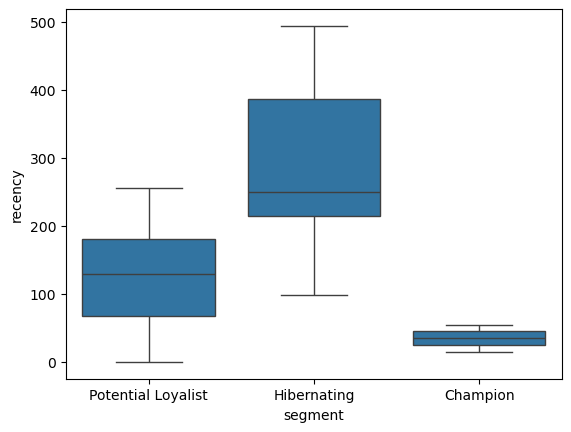

In [50]:
sns.boxplot(x='segment', y='recency', data=rfm_df)
plt.show()

##### Frequency

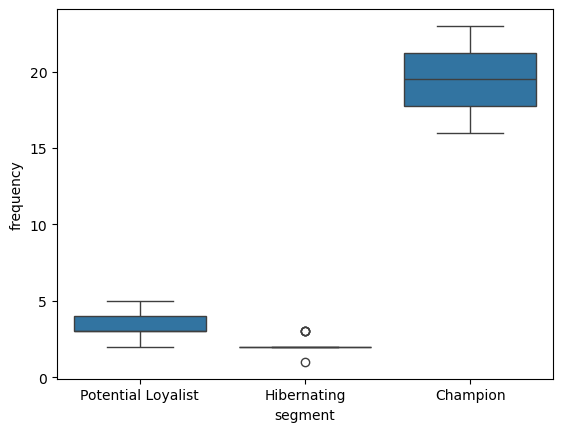

In [51]:
sns.boxplot(x='segment', y='frequency', data=rfm_df)
plt.show()

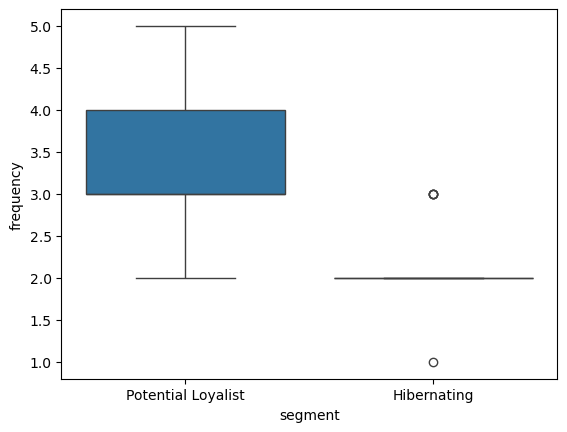

In [140]:
sns.boxplot(x='segment', y='frequency', data=rfm_df[rfm_df.segment != 'Champion'])
plt.show()

##### Monetary

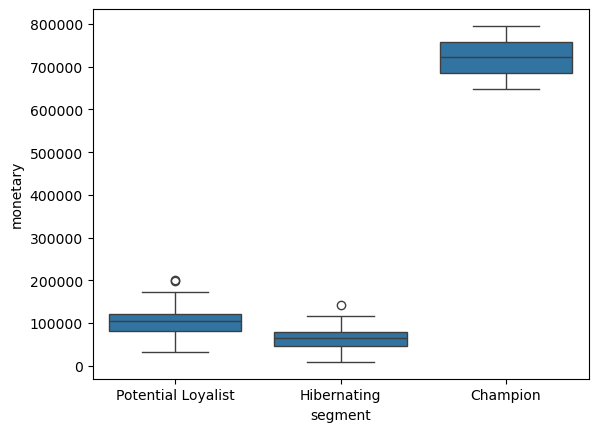

In [52]:
sns.boxplot(x='segment', y='monetary', data=rfm_df)
plt.show()

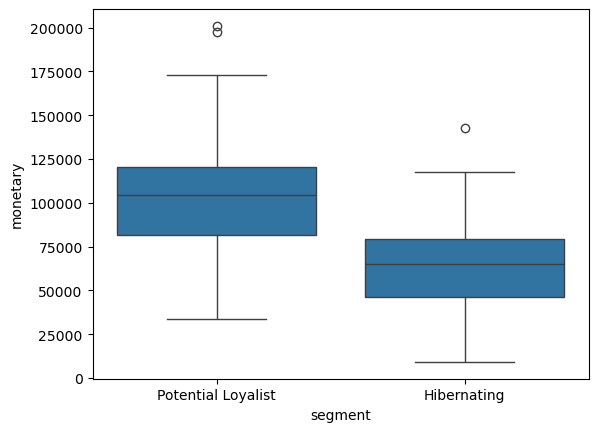

In [139]:
sns.boxplot(x='segment', y='monetary', data=rfm_df[rfm_df.segment != 'Champion'])
plt.show()

### Overall

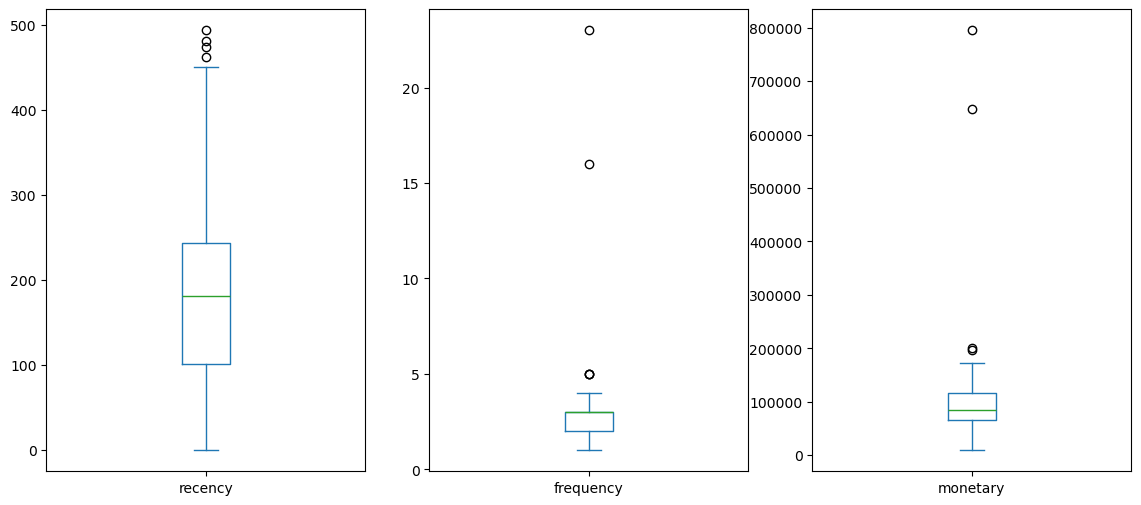

In [53]:
rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

## Pie Charts & Quick Stats

,segment,Recency_mean,Frequency_mean,Monetary_mean,Monetary_total,count
0,Champion,34.500000,19.500000,721462.265000,1442924.53,2
1,Potential Loyalist,120.132075,3.283019,106400.755283,5639240.03,53
2,Hibernating,296.135135,2.081081,63785.264865,2360054.80,37


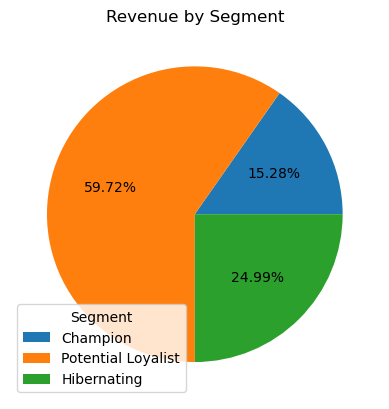

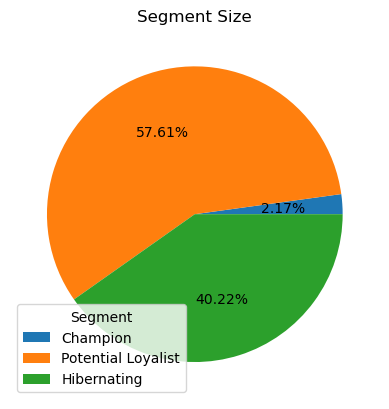

In [54]:
# build summary table of means and revenue/size totals
rfm_cols = ['recency', 'frequency', 'monetary']

segment_summary_df = (
    rfm_df.groupby('segment').agg(
        Recency_mean        = ('recency', 'mean'),
        Frequency_mean      = ('frequency', 'mean'),
        Monetary_mean       = ('monetary', 'mean'),
        Monetary_total      = ('monetary', 'sum'),
        count               = ('segment', 'count')
    ).sort_values('Monetary_mean', ascending=False).reset_index()
)

# ----displays------------------------------
# summary table
display(segment_summary_df)

# pie chart: segments' revenue proportions 
segment_summary_df.plot.pie(
    y='Monetary_total', labels=segment_summary_df['segment'],
    autopct='%1.2f%%', labeldistance=None, ylabel='', title='Revenue by Segment'
    
)
plt.legend(loc='lower left', title='Segment')
plt.show()

# pie chart: segments' proportion of customers
segment_summary_df.plot.pie(
    y='count', labels=segment_summary_df['segment'], 
    autopct='%1.2f%%', labeldistance=None, ylabel='', title='Segment Size'
)
plt.legend(loc='lower left', title='Segment')
plt.show()

In [61]:
for col in rfm_cols:
    display(rfm_df.groupby('segment').agg({
    col: ['mean', 'median', 'std', 'min', 'max']
    }).round(2))

recency                        
                      mean median     std min  max
segment                                           
Champion             34.50   34.5   28.99  14   55
Hibernating         296.14  250.0  108.63  98  494
Potential Loyalist  120.13  130.0   65.47   0  256

frequency                     
                        mean median   std min max
segment                                          
Champion               19.50   19.5  4.95  16  23
Hibernating             2.08    2.0  0.36   1   3
Potential Loyalist      3.28    3.0  0.63   2   5

monetary                                            
                         mean     median        std        min        max
segment                                                                  
Champion            721462.26  721462.26  104462.24  647596.31  795328.22
Hibernating          63785.26   64834.32   28245.90    9129.35  142874.25
Potential Loyalist  106400.76  104370.38   34496.89   33440.10  200995.41

# Save Final
---

## Analysis date range

In [153]:
# get analysis time range decided before
%store -r rfm_date_range
display(rfm_date_range)

{'start_date': '2003-01-06', 'end_date': '2005-05-17'}

In [154]:
# save date range into json for later db input
with open('../config/rfm_dates.json', 'w') as fp:
    json.dump(rfm_date_range, fp)

## RFM values with labels

In [155]:
# prepare to store results
final_rfm_df = rfm_df.copy()
final_rfm_df.monetary = final_rfm_df.monetary.round(2)
final_rfm_df = final_rfm_df.rename(columns={
    'recency': 'recency_days',
    'monetary': 'monetary_amt',
    'segment': 'label'
}).reset_index()
display(final_rfm_df.head())

# store data
final_rfm_df.to_csv('../data/derived/rfm_labels.csv', index=False)

,customer_id,recency_days,frequency,monetary_amt,label
0,1,183,3,118711.78,Potential Loyalist
1,2,213,2,100306.58,Hibernating
2,3,188,4,119028.73,Potential Loyalist
3,4,441,3,142874.25,Hibernating
4,5,132,4,120783.07,Potential Loyalist
